# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75.

## Откройте и изучите файл

In [112]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import tree

In [113]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [114]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [116]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [117]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Количество минут и Количество звонков имеют сильную взаимную корреляцию.

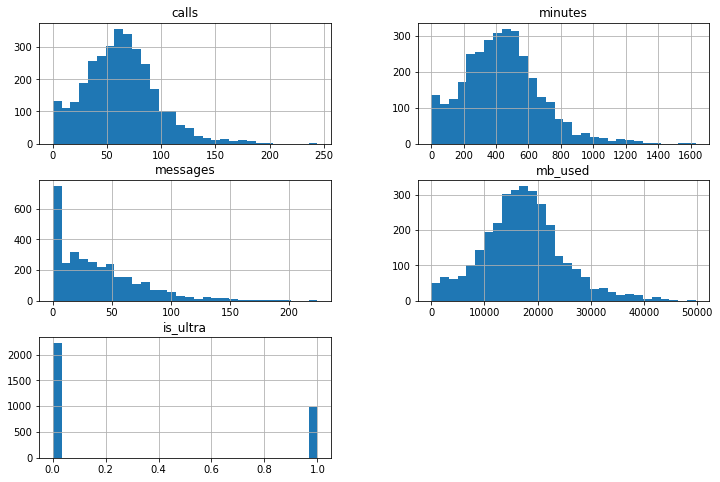

In [118]:
df.hist(bins=30,figsize=[12,8]);

Из графика с признаком тарифов видно, что данных для тарифа "Смарт" больше в 2 раза, чем для тарифа "Ульра", что может сказаться на адекватности результатов предсказания итоговой модели.

## Разбейте данные на выборки

Так как отдельных тестовых данных нет, то разобъем наш единственный датасет на обучающую, тестовую и валидационные выборки в пропорции

60 - 20 - 20


In [119]:
# Делим датасет на features и target
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

# Создаем выборки для обучения/валидациии и для теста со стратификацией
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)

# Делим общую выборку для обучения/валидации на части со стратификацией
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=12345, stratify=target_train_valid)



Проверим, правильно ли разделили выборки

In [120]:
print('Кол-во записей в features и target общих данных: ',[features.shape[0],target.shape[0]])
print('Кол-во записей в features и target обучающей выборки: ',[features_train.shape[0],target_train.shape[0]])
print('Кол-во записей в features и target валидационной выборки: ',[features_valid.shape[0],target_valid.shape[0]])
print('Кол-во записей в features и target тестовой выборки: ',[features_test.shape[0],target_test.shape[0]])

Кол-во записей в features и target общих данных:  [3214, 3214]
Кол-во записей в features и target обучающей выборки:  [1928, 1928]
Кол-во записей в features и target валидационной выборки:  [643, 643]
Кол-во записей в features и target тестовой выборки:  [643, 643]


## Исследуйте модели

Обучим три вида моделей и подберем оптимальные гиперпараметры для каждой.\
Оценивать качество моделей будем метрикой accuracy, потому что нам важна точность предсказания, от этого зависит доход компании.

### Решающее дерево

In [121]:
best_result = 0
depth_list = []
accuracy_list = []

for depth in tqdm(range(1, 101)):
    
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train,target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    
    depth_list.append(depth)
    accuracy_list.append(result)
    
    if result > best_result:
        best_tree_model = model
        best_result = result
        best_depth = depth
        
print("Accuracy лучшей модели:", best_result)
print("Глубина лучшей модели:", best_depth)

100%|██████████| 100/100 [00:01<00:00, 74.89it/s]

Accuracy лучшей модели: 0.8164852255054432
Глубина лучшей модели: 5


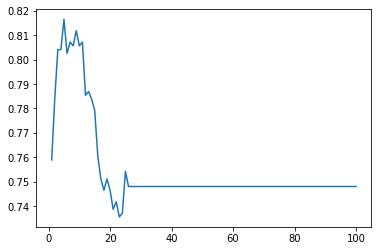

In [122]:
plt.plot(depth_list,accuracy_list);

Пик точности приходится на грубину = 5, затем точность резко падает до 73%.\
Глубина более 26 перестает влиять на точность предсказания.

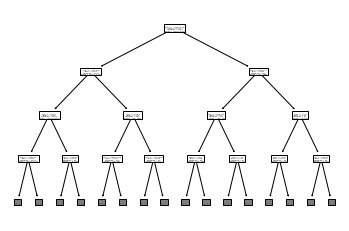

In [123]:
tree.plot_tree(best_tree_model,max_depth=3);

### Случайный лес

In [124]:
best_result = 0

depth_list_rf = []
accuracy_list_rf = []
estimators_list_rf = []

for est in tqdm(range(1, 30)):
    for depth in range (1,20):

        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train,target_train)
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions)

        if result > best_result:
            best_forest_model = model
            best_result = result
            best_depth = depth
            best_est = est
        
    accuracy_list_rf.append(best_result)
    estimators_list_rf.append(est)
        
print("Accuracy лучшей модели:", best_result)
print("Количество деревьев лучшей модели:", best_est)
print("Глубина лучшей модели:", best_depth)

100%|██████████| 29/29 [00:32<00:00,  1.12s/it]

Accuracy лучшей модели: 0.8320373250388803
Количество деревьев лучшей модели: 10
Глубина лучшей модели: 8


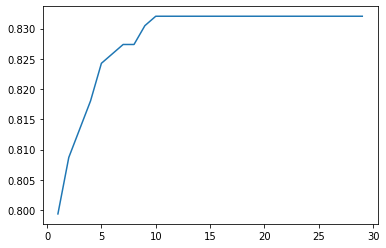

In [125]:
plt.plot(estimators_list_rf,accuracy_list_rf);

Начиная с 10 увеличение количества деревьев не влияет на точность

### Логистическая регрессия

In [126]:
best_result = 0

iter_list_lr = []
accuracy_list_lr = []

for iter_ in tqdm(range(1000,110000,1000)):

    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=iter_)
    model.fit(features_train,target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    if result > best_result:
        best_log_regression_model = model
        best_result = result
        best_iter = iter_
    
    iter_list_lr.append(iter_)
    accuracy_list_lr.append(result)
        
print("Accuracy лучшей модели:", best_result)
print("Количество итераций обучения лучшей модели:", best_iter)


100%|██████████| 109/109 [00:03<00:00, 27.58it/s]

Accuracy лучшей модели: 0.7558320373250389
Количество итераций обучения лучшей модели: 1000


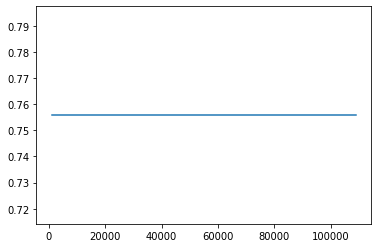

In [127]:
plt.plot(iter_list_lr,accuracy_list_lr);

При использовании логистической регрессии, в данном случае нет никакой зависимости от количества итераций более 1000

Обучив 3 вида моделей с разными гиперпараметрами очевидно, что модель "Случайный лес" - показывает самую высокую точность предсказания.\
Гиперпараметры лучшей модели данного вида:
- Количество деревьев: 10
- Глубина: 8

## Проверьте модель на тестовой выборке

Проверим лучшую модель на тестовой выборке

In [128]:
predictions_forest = best_forest_model.predict(features_test)
result = accuracy_score(target_test, predictions_forest)
print("Accuracy модели:", result)

Accuracy модели: 0.8102643856920684


Проверка лучшей моделей на тестовой выборке показала точность прогноза = 81%

In [129]:
model_plus = RandomForestClassifier(random_state=12345, n_estimators=10, max_depth=8)

train_val_features = pd.concat([features_train,features_valid])
train_val_target = pd.concat([target_train,target_valid])

model_plus.fit(train_val_features,train_val_target)
predictions = model_plus.predict(features_test)

result = accuracy_score(target_test, predictions)
print("Accuracy модели:", result)

Accuracy модели: 0.8149300155520995


Если обучить нашу лучшую модель с оптимальными гиперпараметрами на обучающей + валидационной выборке, то получим увеличение точности на 0,5%, итого - 81,5% (при целевой 75%, цель достигнута)

## (бонус) Проверьте модели на адекватность

Проверим точность лучшей модели, подавая на вход данные только тарифа "Смарт" (значение "0")

In [138]:
df_zero = df.loc[df.is_ultra == 0]

# Делим датасет на features и target
features_zero = df_zero.drop(['is_ultra'], axis=1)
target_zero = df_zero['is_ultra']

# Создаем выборки для обучения/валидациии и для теста со стратификацией
features_train_valid, features_zero_test, target_train_valid, target_zero_test = train_test_split(
    features_zero, target_zero, test_size=0.2, random_state=12345, stratify=target_zero)


model_plus.fit(train_val_features,train_val_target)
predictions = model_plus.predict(features_zero_test)

result = accuracy_score(target_zero_test, predictions)
print("Accuracy модели:", result)

Accuracy модели: 0.9506726457399103


Проверим точность лучшей модели, подавая на вход данные только тарифа "Ультра" (значение "1")

In [139]:
df_one = df.loc[df.is_ultra == 1]

# Делим датасет на features и target
features_one = df_one.drop(['is_ultra'], axis=1)
target_one = df_one['is_ultra']

# Создаем выборки для обучения/валидациии и для теста со стратификацией
features_train_valid, features_one_test, target_train_valid, target_one_test = train_test_split(
    features_one, target_one, test_size=0.2, random_state=12345, stratify=target_one)


model_plus.fit(train_val_features,train_val_target)
predictions = model_plus.predict(features_one_test)

result = accuracy_score(target_one_test, predictions)
print("Accuracy модели:", result)

Accuracy модели: 0.5888324873096447


Как видно из значений точности из-за дисбаланса в количестве объектов двух тарифов модель намного лучше предсказывает для тарифа "Смарт".